# RILA Price Elasticity Analysis - Refactored Pipeline Architecture

**Refactored:** 2025-10-27 - One Pipeline Per Cell Block
**Original:** notebooks/00_data_pipeline.ipynb
**Mathematical Equivalence:** Validated per Universal Refactoring Rules

## Refactoring Improvements
- **One Pipeline Per Cell**: Each of the 10 pipeline functions isolated in dedicated cells
- **Enhanced Documentation**: Business purpose + technical specifications for each pipeline
- **Improved DVC Integration**: Strategic checkpoints and optimized tracking
- **Better Organization**: Clear separation of concerns and logical flow
- **Atomic Refactoring Ready**: Each pipeline can be independently modified and validated

## Data Flow Overview
1. **Sales Pipeline**: Product filtering → cleanup → time series (app & contract dates)
2. **WINK Pipeline**: Rate processing → market share weighting (separate for DRY)
3. **Feature Pipeline**: Data integration → competitive features → weekly aggregation → lag engineering → final prep

## Pipeline Functions (10 Total)
1. `apply_product_filters()` - Standard annuity product filtering
2. `apply_sales_data_cleanup()` - Comprehensive sales data preparation
3. `apply_application_time_series()` - Application date time series
4. `apply_contract_time_series()` - Contract date time series
5. `apply_wink_rate_processing()` - WINK competitive rate processing (no C_weighted_mean)
6. `apply_market_share_weighting()` - Market share weighting (creates C_weighted_mean)
7. `apply_data_integration()` - Daily data integration without weekly aggregation
8. `apply_competitive_features()` - Atomic competitive functions (clean semantic names)
9. `apply_weekly_aggregation()` - Weekly aggregation after competitive features
10. `apply_lag_and_polynomial_features()` - 13 lag configs + polynomial interactions
11. `apply_final_feature_preparation()` - Temporal features, spreads, cleanup

## Table of Contents
* [Section 1: Configuration & Setup](#sec1:config)
* [Section 2: Data Connection & Loading](#sec2:data_loading)
* [Section 3: Sales Data Processing](#sec3:sales)
* [Section 4: Competitive Rate Analysis](#sec4:rates)
* [Section 5: Feature Engineering](#sec5:features)
* [Section 6: Final Export & Visualization](#sec6:final)

## Section 1: Configuration & Setup <a id="sec1:config"></a>

In [1]:
%%capture
# =============================================================================
# UNIFIED DEPENDENCY PATTERN: Clean Organization
# =============================================================================

# Standard library imports (consistent across all notebooks)
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy.special import logit, expit

# Suppress warnings for clean output
warnings.filterwarnings("ignore")

# Canonical sys.path setup following MODULE_HIERARCHY.md
project_root = '/home/sagemaker-user/ann_price_elasticity_rila_with_6y20'
import sys
sys.path.insert(0, project_root)

# Clean imports with centralized error handling in modules
from src.data import extraction as ext
from src.data import preprocessing as prep
from src.data import pipelines
from src.data.dvc_manager import save_dataset, load_dataset, checkpoint_pipeline
from src.data.schema_validator import validate_pipeline_input, validate_pipeline_output
from src.features import engineering as eng
from src.visualization import visualization as viz
from src.config import config_builder

# Load performance tracking extension
try:
    %load_ext autotime
except:
    %pip install ipython-autotime
    %load_ext autotime

# Apply consistent visualization theme
sns.set_theme(style="whitegrid", palette="deep")

print("Dependencies loaded successfully")

time: 953 μs (started: 2026-01-15 23:32:12 +00:00)


In [2]:

# Type hints for configuration
from typing import Dict, List, Any
# =============================================================================
# PIPELINE CONFIGURATION - STREAMLINED SETUP
# =============================================================================

# AWS Infrastructure Configuration (unchanged)
aws_config: Dict[str, str] = {
    'xid': "x259830",
    'role_arn': "arn:aws:iam::159058241883:role/isg-usbie-annuity-CA-s3-sharing",
    'sts_endpoint_url': "https://sts.us-east-1.amazonaws.com",
    'source_bucket_name': "pruvpcaws031-east-isg-ie-lake",
    'output_bucket_name': "cdo-annuity-364524684987-bucket",
    'output_base_path': "ANN_Price_Elasticity_Data_Science"
}

# Business Parameters (will be passed to config builder)
product_name = "FlexGuard indexed variable annuity"
term_filter = "6Y"
buffer_rate_filter = "20%"
version = 6 

# Build all 10 pipeline configurations using config builder
configs: Dict[str, Any] = config_builder.build_pipeline_configs(
    version=version,
    product_name=product_name,
    term_filter=term_filter,
    buffer_rate_filter=buffer_rate_filter
)

# FlexGuard competitor product IDs (for market share weighting)
flexguard_product_ids = {
    "Prudential": [2979],
    "Allianz": [2162, 3699],
    "Athene": [3409],
    "Brighthouse": [2319, 4149],
    "Equitable": [3282],
    "Jackson": [3351, 4491],
    "Lincoln": [2358, 4058],
    "Symetra": [3263],
    "Trans": [3495],
}

# Visualization Parameters
fig_width = 20
fig_height = 6
line_width = 3

print(f"SUCCESS: Configuration system loaded")
print(f"   Product: {product_name} {term_filter} {buffer_rate_filter}")
print(f"   Version: {version}")
print(f"   Pipeline configs: {list(configs.keys())}")

SUCCESS: Configuration system loaded
   Product: FlexGuard indexed variable annuity 6Y 20%
   Version: 6
   Pipeline configs: ['product_filter', 'sales_cleanup', 'time_series', 'wink_processing', 'data_integration', 'weekly_aggregation', 'competitive', 'lag_features', 'final_features']
time: 1.42 ms (started: 2026-01-15 23:32:12 +00:00)


## Section 2: Data Connection & Loading <a id="sec2:data_loading"></a>

### AWS Connection & Authentication Setup

**Business Purpose**: Establish secure connection to Prudential data sources for sales and competitive rate data

**Technical Function**: Creates STS client, assumes IAM role, and establishes S3 resource with proper credentials

**Key Components**:
- STS client creation for role assumption
- IAM role assumption for cross-account access
- S3 resource creation with assumed credentials
- Bucket access for data lake queries

In [3]:
# =============================================================================
# AWS CONNECTION: Secure Authentication
# =============================================================================

# AWS Connection using granular functions with built-in error handling
sts_client = ext.setup_aws_sts_client_with_validation(aws_config)
assumed_role = ext.assume_iam_role_with_validation(sts_client, aws_config)
s3_resource, bucket = ext.setup_s3_resource_with_validation(assumed_role['Credentials'], aws_config['source_bucket_name'])

print(f"AWS connection established successfully:")
print(f"   Source bucket: {aws_config['source_bucket_name']}")
print(f"   Role ARN: {aws_config['role_arn']}")
print(f"   XID: {aws_config['xid']}")

AWS connection established successfully:
   Source bucket: pruvpcaws031-east-isg-ie-lake
   Role ARN: arn:aws:iam::159058241883:role/isg-usbie-annuity-CA-s3-sharing
   XID: x259830
time: 330 ms (started: 2026-01-15 23:32:12 +00:00)


### Sales Data Loading

**Business Purpose**: Load all available FlexGuard sales data from Prudential's data lake for analysis

**Technical Function**: Discovers and loads all parquet files from sales data partition, concatenates into single DataFrame

**Input**: S3 parquet files from `access/ierpt/tde_sales_by_product_by_fund/`

**Output**: Combined sales DataFrame (~1.4M rows, 133 columns)

**Performance Notes**: Uses parallel loading and efficient concatenation for large datasets

In [4]:
# =============================================================================
# SALES DATA LOADING: Comprehensive S3 Loading
# =============================================================================

# Load sales data using granular function with built-in validation
df_combined: pd.DataFrame = ext.discover_and_load_sales_data(bucket, s3_resource, aws_config['source_bucket_name'])

print(f"Sales data loading completed:")
print(f"   Total records: {df_combined.shape[0]:,}")
print(f"   Total columns: {df_combined.shape[1]}")
print(f"   Date range: {df_combined['application_signed_date'].min()} to {df_combined['application_signed_date'].max()}")
print(f"   All required columns present for pipeline processing")

Sales data loading completed:
   Total records: 2,817,439
   Total columns: 133
   Date range: 1900-01-01 to 2026-01-13
   All required columns present for pipeline processing
time: 19.1 s (started: 2026-01-15 23:32:12 +00:00)


### WINK Competitive Rate Data Loading

**Business Purpose**: Load competitive annuity rate data from WINK system for market analysis

**Technical Function**: Loads and concatenates competitive rate data from all available time periods

**Input**: S3 parquet files from `access/ierpt/wink_ann_product_rates/`

**Output**: Combined WINK DataFrame (~1M+ rows, 77 columns)

**Key Data**: Competitive rates from major annuity providers for market positioning analysis

In [5]:
# =============================================================================
# WINK DATA LOADING: Competitive Rate Data
# =============================================================================

# Load WINK competitive data using granular function with built-in validation
df_wink: pd.DataFrame = ext.discover_and_load_wink_data(bucket, s3_resource, aws_config['source_bucket_name'])

rate_columns = [col for col in df_wink.columns if 'rate' in col.lower()]

print(f"WINK data loading completed:")
print(f"   Total records: {df_wink.shape[0]:,}")
print(f"   Total columns: {df_wink.shape[1]}")
print(f"   Company coverage: {len(rate_columns)} rate columns")
print(f"   All required columns present for competitive analysis")

WINK data loading completed:
   Total records: 1,093,271
   Total columns: 78
   Company coverage: 35 rate columns
   All required columns present for competitive analysis
time: 5.02 s (started: 2026-01-15 23:32:31 +00:00)


## Section 3: Sales Data Processing <a id="sec3:sales"></a>

### Pipeline 1: Product Filtering

**Business Purpose**: Filter dataset to FlexGuard 6Y 20% buffer rate products only, removing irrelevant product variations

**Technical Function**: Applies product name, term, and buffer rate filters using config-driven selection criteria

**Input**: Raw sales data (1,406,931 rows, 133 columns)

**Output**: Filtered sales data (~68,412 rows, 133 columns)

**Key Parameters**: product_name="FlexGuard indexed variable annuity", term_filter="6Y", buffer_rate_filter="20%"

**Why This Matters**:
- Focuses on $900M+ annual sales volume in RILA category
- 96% data reduction enables efficient downstream processing
- Targets strategic competitive segment for pricing analysis

In [6]:
# =============================================================================
# PIPELINE 1: PRODUCT FILTERING
# =============================================================================

df_product_filtered: pd.DataFrame = pipelines.apply_product_filters(df_combined, configs['product_filter'])

if df_product_filtered.empty:
    raise ValueError("Product filtering resulted in empty dataset")

retention_rate = len(df_product_filtered)/len(df_combined)*100

print(f"Pipeline 1 - Product filtering:")
print(f"   {len(df_combined):,} → {len(df_product_filtered):,} records ({retention_rate:.1f}%)")

Pipeline 1 - Product filtering:
   2,817,439 → 95,371 records (3.4%)
time: 3.77 s (started: 2026-01-15 23:32:36 +00:00)


### Pipeline 2: Sales Data Cleanup

**Business Purpose**: Clean and validate sales data for analysis, removing invalid records and standardizing formats

**Technical Function**: Applies data quality checks, handles missing values, and standardizes date formats

**Input**: Filtered sales data (~68,412 rows, 133 columns)

**Output**: Clean sales data (~66,894 rows, 134 columns)

**Why This Matters**:
- Data quality directly impacts $900M+ pricing strategy decisions
- Historical data preservation ensures 4+ years for model training
- Invalid records could skew competitive analysis by 5-10%

**Key Operations**: Date validation, null value handling, data type conversions, business rule validation

In [7]:
# =============================================================================
# PIPELINE 2: SALES DATA CLEANUP
# =============================================================================
df_FlexGuard: pd.DataFrame = pipelines.apply_sales_data_cleanup(df_product_filtered, configs['sales_cleanup'])
print(f"SUCCESS: Pipeline 2 - Sales cleanup: {df_FlexGuard.shape}")
print(f"   Records cleaned: {len(df_product_filtered) - len(df_FlexGuard):,} invalid records removed")
print(f"   Data quality: {len(df_FlexGuard)/len(df_product_filtered)*100:.1f}% records passed validation")

SUCCESS: Pipeline 2 - Sales cleanup: (93315, 134)
   Records cleaned: 2,056 invalid records removed
   Data quality: 97.8% records passed validation
time: 1.44 s (started: 2026-01-15 23:32:40 +00:00)


In [8]:
# =============================================================================
# PRODUCTION VALIDATION: Sales Data Quality
# =============================================================================

from pathlib import Path
import json
from src.validation.production_validators import (
    run_production_validation_checkpoint,
    ValidationConfig
)

config: ValidationConfig = {
    'checkpoint_name': 'sales_cleanup',
    'version': version,
    'project_root': project_root,
    'strict_schema': True,
    'growth_config': {
        'min_growth_pct': -5.0,
        'max_growth_pct': 20.0,
        'warn_on_shrinkage': True,
        'warn_on_high_growth': True
    },
    'critical_columns': None
}

result = run_production_validation_checkpoint(
    df=df_FlexGuard,
    config=config,
    date_column='application_signed_date'
)

print("✓ Production validation passed")

[PASS] Validation passed for sales_cleanup
  Schema stable: 134 columns validated
  Volume growth: 93,315 → 93,315 (+0.0%)
  Date range: 2020-05-18 00:00:00 to 2026-01-09 00:00:00
✓ Production validation passed
time: 3.93 ms (started: 2026-01-15 23:32:42 +00:00)


### Pipeline 3A: Application Time Series

**Business Purpose**: Create time series based on application signed dates to track when customers applied for policies

**Technical Function**: Aggregates sales data by application_signed_date, creates daily time series with sales totals

**Input**: Clean sales data (~66,894 rows)

**Output**: Application time series (1,777 rows, 2 columns: date, sales)

**Key Parameters**: date_column='application_signed_date', alias_value_col='sales'

**Why This Matters**:
- Application dates prevent time-ordering leakage in models
- Daily granularity captures sales momentum patterns
- Critical for understanding customer decision timing

In [9]:
# =============================================================================
# PIPELINE 3A: APPLICATION TIME SERIES
# =============================================================================

# Application date time series
app_config = configs['time_series'].copy()
app_config['date_column'] = 'application_signed_date'
app_config['alias_value_col'] = 'sales'
df_sales_app: pd.DataFrame = pipelines.apply_application_time_series(df_FlexGuard, app_config)
print(f"SUCCESS: Pipeline 3a - Application time series: {df_sales_app.shape}")
print(f"   Date range: {df_sales_app.index.min()} to {df_sales_app.index.max()}")
print(f"   Daily sales range: ${df_sales_app['sales'].min():,.0f} to ${df_sales_app['sales'].max():,.0f}")

SUCCESS: Pipeline 3a - Application time series: (2063, 2)
   Date range: 0 to 2062
   Daily sales range: $214,817 to $26,759,063
time: 19.6 ms (started: 2026-01-15 23:32:42 +00:00)


### Pipeline 3B: Contract Time Series

**Business Purpose**: Create time series based on contract issue dates to track when policies were actually issued

**Technical Function**: Aggregates sales data by contract_issue_date, creates daily time series with contract sales totals

**Input**: Clean sales data (~66,894 rows)

**Output**: Contract time series (1,744 rows, 2 columns: date, sales_by_contract_date)

**Key Parameters**: date_column='contract_issue_date', alias_value_col='sales_by_contract_date'

**Why This Matters**:
- Contract dates track actual policy issuance
- Processing lag analysis supports forecasting models
- Alternative time series for validation checks

In [10]:
# =============================================================================
# PIPELINE 3B: CONTRACT TIME SERIES
# =============================================================================

# Contract date time series
contract_config = configs['time_series'].copy()
contract_config['date_column'] = 'contract_issue_date'
contract_config['alias_value_col'] = 'sales_by_contract_date'
df_sales_contract: pd.DataFrame = pipelines.apply_contract_time_series(df_FlexGuard, contract_config)
print(f"SUCCESS: Pipeline 3b - Contract time series: {df_sales_contract.shape}")
print(f"   Date range: {df_sales_contract.index.min()} to {df_sales_contract.index.max()}")
print(f"   Contract sales range: ${df_sales_contract['sales_by_contract_date'].min():,.0f} to ${df_sales_contract['sales_by_contract_date'].max():,.0f}")

SUCCESS: Pipeline 3b - Contract time series: (2060, 2)
   Date range: 0 to 2059
   Contract sales range: $25,007 to $21,005,129
time: 17.9 ms (started: 2026-01-15 23:32:42 +00:00)


### Sales Data Export & DVC Tracking

**Business Purpose**: Persist sales time series data for downstream use and maintain version control for reproducibility

**Technical Function**: Exports to parquet format, adds DVC tracking, and syncs with S3 remote storage

**Output Files**:
- `outputs/datasets/FlexGuard_Sales.parquet` (application-based time series)
- `outputs/datasets/FlexGuard_Sales_contract.parquet` (contract-based time series)

**DVC Integration**: Automatic tracking and S3 remote synchronization for data lineage

In [11]:
# =============================================================================
# SALES DATA EXPORT
# =============================================================================

# Save datasets with DVC tracking
save_dataset(df_sales_app, "FlexGuard_Sales")
save_dataset(df_sales_contract, "FlexGuard_Sales_contract")

print(f"Sales processing complete:")
print(f"   Application series: {df_sales_app.shape}")
print(f"   Contract series: {df_sales_contract.shape}")

DVC add failed for FlexGuard_Sales.parquet: [Errno 2] No such file or directory: 'dvc'


Background DVC push failed for FlexGuard_Sales.parquet: [Errno 2] No such file or directory: 'dvc'


DVC add failed for FlexGuard_Sales_contract.parquet: [Errno 2] No such file or directory: 'dvc'


Background DVC push failed for FlexGuard_Sales_contract.parquet: [Errno 2] No such file or directory: 'dvc'


Sales processing complete:
   Application series: (2063, 2)
   Contract series: (2060, 2)
time: 12.4 ms (started: 2026-01-15 23:32:42 +00:00)


## Section 4: Competitive Rate Analysis <a id="sec4:rates"></a>

### Pipeline 4: WINK Rate Processing

**Business Purpose**: Process competitive rates from WINK system without market share weighting (DRY compliance - separation of concerns)

**Technical Function**: Filters, cleans, and standardizes competitive rate data from multiple insurance companies

**Input**: Raw WINK data (1,075,628 rows, 77 columns)

**Output**: Processed rates (2,686 rows, 10 columns)

**Key Parameters**: Company filters, rate type selections, date range filtering

**Why This Matters**:
- Competitive intelligence from 8 major carriers
- Rate changes drive 2-3% sales impact per basis point
- Daily updates enable rapid competitive response

**Note**: Does NOT create C_weighted_mean (handled separately in Pipeline 5 for DRY compliance)

In [12]:
# =============================================================================
# PIPELINE 4: WINK RATE PROCESSING (NO C_weighted_mean creation)
# =============================================================================
df_wink_rates: pd.DataFrame = pipelines.apply_wink_rate_processing(df_wink, configs['wink_processing'])
print(f"SUCCESS: Pipeline 4 - WINK rate processing: {df_wink_rates.shape}")
print(f"   Data reduction: {len(df_wink):,} → {len(df_wink_rates):,} rows")
print(f"   Company columns: {[col for col in df_wink_rates.columns if col in ['Prudential', 'Allianz', 'Athene']]}")
print(f"   Date range: {df_wink_rates['date'].min()} to {df_wink_rates['date'].max()}")

SUCCESS: Pipeline 4 - WINK rate processing: (2766, 10)
   Data reduction: 1,093,271 → 2,766 rows
   Company columns: ['Prudential', 'Allianz', 'Athene']
   Date range: 2018-06-21 00:00:00 to 2026-01-15 00:00:00
time: 8.88 s (started: 2026-01-15 23:32:42 +00:00)


### Pipeline 5: Market Share Weighting

**Business Purpose**: Apply market share weights to create competitive averages - separated from WINK processing for DRY compliance

**Technical Function**: Loads market share weights and creates weighted competitive features including C_weighted_mean and C_core

**Input**: Processed WINK rates (2,686 rows, 10 columns)

**Output**: Weighted rates (2,686 rows, 25 columns)

**Why This Matters**:
- Distribution reach determines competitive impact
- Market share proxies for sales force effectiveness
- Quarterly weights capture evolving competitive landscape

**Key Features Created**: C_weighted_mean, C_core, and other market-share weighted competitive metrics

**Market Share Source**: S3-stored quarterly market share weights for FlexGuard competitive set

In [13]:
# =============================================================================
# PIPELINE 5: MARKET SHARE WEIGHTING (Creates C_weighted_mean - DRY compliance)
# =============================================================================

# Load market share weights from S3
market_share_s3_path = "s3://cdo-annuity-364524684987-bucket/ANN_Price_Elasticity_Data_Science/flex_guard_market_share_2025_10_01.parquet"
df_quarter_weights: pd.DataFrame = ext.load_market_share_weights_from_s3(market_share_s3_path)
print(f"Market share weights loaded: {df_quarter_weights.shape}")

# Apply market share weighting (creates C_weighted_mean and C_core)
df_wink_rates_weighted: pd.DataFrame = pipelines.apply_market_share_weighting(df_wink_rates, df_quarter_weights)
print(f"SUCCESS: Pipeline 5 - Market share weighting: {df_wink_rates_weighted.shape}")
print(f"   New columns added: {df_wink_rates_weighted.shape[1] - df_wink_rates.shape[1]}")
print(f"   Weighted features: {[col for col in df_wink_rates_weighted.columns if col.startswith('C_')]}")

Market share weights loaded: (19, 11)
SUCCESS: Pipeline 5 - Market share weighting: (2766, 25)
   New columns added: 15
   Weighted features: ['C_weighted_mean', 'C_core']
time: 328 ms (started: 2026-01-15 23:32:51 +00:00)


### WINK Data Export & DVC Tracking + Checkpoint

**Business Purpose**: Persist weighted competitive rates for downstream feature engineering and maintain data lineage

**Technical Function**: Exports weighted rates to parquet, adds DVC tracking with strategic checkpoint for competitive data

**Output Files**:
- `outputs/datasets/WINK_competitive_rates.parquet` (weighted competitive rates)

**DVC Integration**: Checkpoint created here for competitive rate processing milestone

**Strategic Value**: Allows independent reuse of processed competitive rates for other analyses

In [14]:
# =============================================================================
# COMPETITIVE RATES EXPORT
# =============================================================================

save_dataset(df_wink_rates_weighted, "WINK_competitive_rates")

print(f"Competitive rate processing complete:")
print(f"   Weighted rates: {df_wink_rates_weighted.shape}")
print(f"   Key features: C_weighted_mean, C_core created")

DVC add failed for WINK_competitive_rates.parquet: [Errno 2] No such file or directory: 'dvc'


Background DVC push failed for WINK_competitive_rates.parquet: [Errno 2] No such file or directory: 'dvc'


Competitive rate processing complete:
   Weighted rates: (2766, 25)
   Key features: C_weighted_mean, C_core created
time: 12.5 ms (started: 2026-01-15 23:32:51 +00:00)


## Section 5: Feature Engineering <a id="sec5:features"></a>

### Economic Data Loading

**Business Purpose**: Load macroeconomic indicators (interest rates, market volatility, inflation) that impact annuity sales

**Technical Function**: Loads DGS5 (5-year Treasury), VIX (volatility), and CPI (inflation) data from S3 and DVC-tracked local files

**Data Sources**:
- DGS5: 5-year Treasury rates (interest rate environment)
- VIX: Market volatility index (market uncertainty)
- CPI: Consumer price index scaled (inflation adjustment)
- Sales data: Previously processed and DVC-tracked sales time series

**Integration Strategy**: Combines external economic data with internal sales and competitive data

In [15]:
# =============================================================================
# ECONOMIC AND SALES DATA LOADING
# =============================================================================

# Load economic data from S3
file_name_dgs5 = "MACRO_ECONOMIC_DATA/DGS5_index"
file_name_vixcls = "MACRO_ECONOMIC_DATA/VIXCLS_index"
file_name_cpi = "MACRO_ECONOMIC_DATA/cpi_scaled"

df_rates: pd.DataFrame = df_wink_rates_weighted
df_dgs5: pd.DataFrame = ext.download_s3_parquet_with_optional_date_suffix(aws_config['output_bucket_name'], f"{aws_config['output_base_path']}/{file_name_dgs5}", None)
df_vixcls: pd.DataFrame = ext.download_s3_parquet_with_optional_date_suffix(aws_config['output_bucket_name'], f"{aws_config['output_base_path']}/{file_name_vixcls}", None)
df_cpi: pd.DataFrame = ext.download_s3_parquet_with_optional_date_suffix(aws_config['output_bucket_name'], f"{aws_config['output_base_path']}/{file_name_cpi}", None)

# Load from DVC-tracked datasets
df_sales_reload: pd.DataFrame = load_dataset("FlexGuard_Sales")
df_sales_contract_reload: pd.DataFrame = load_dataset("FlexGuard_Sales_contract")

print(f"Economic and sales data loaded:")
print(f"   DGS5: {df_dgs5.shape}, VIX: {df_vixcls.shape}, CPI: {df_cpi.shape}")
print(f"   Sales: {df_sales_reload.shape}, Contract: {df_sales_contract_reload.shape}")

Economic and sales data loaded:
   DGS5: (15870, 2), VIX: (8823, 2), CPI: (6293, 3)
   Sales: (2063, 2), Contract: (2060, 2)
time: 601 ms (started: 2026-01-15 23:32:51 +00:00)


### Pipeline 6: Data Integration

**Business Purpose**: Integrate sales, competitive, and economic data on daily basis without weekly aggregation (preserves granularity)

**Technical Function**: Performs daily merge of all data sources using date as key, maintains daily frequency for subsequent processing

**Input**: Multiple data sources (competitive rates, sales time series, economic indicators)

**Output**: Daily integrated dataset (1,761 rows, 32 columns)

**Why This Matters**:
- Combines sales, competitive, and economic indicators
- Daily frequency preserves temporal precision
- Foundation for all downstream feature engineering

**Key Function**: Daily merge without weekly aggregation - fixed ordering allows competitive features to be created before aggregation

**Business Value**: Maintains temporal granularity for more precise competitive analysis

In [16]:
# =============================================================================
# PIPELINE 6: DATA INTEGRATION (Daily integration without weekly aggregation)
# =============================================================================

data_sources = {
    'sales': df_sales_reload,
    'sales_contract': df_sales_contract_reload,
    'dgs5': df_dgs5,
    'vixcls': df_vixcls,
    'cpi': df_cpi
}

df_daily_integrated: pd.DataFrame = pipelines.apply_data_integration(
    df_rates, data_sources, configs['data_integration']
)

print(f"SUCCESS: Pipeline 6 - Daily data integration: {df_daily_integrated.shape}")
print(f"   Date range: {df_daily_integrated['date'].min()} to {df_daily_integrated['date'].max()}")
print(f"   Integration complete, ready for competitive features")
print(f"   Key columns: {[col for col in df_daily_integrated.columns if col in ['date', 'sales', 'C_weighted_mean', 'DGS5']]}")

SUCCESS: Pipeline 6 - Daily data integration: (1841, 32)
   Date range: 2021-01-01 00:00:00 to 2026-01-15 00:00:00
   Integration complete, ready for competitive features
   Key columns: ['date', 'C_weighted_mean', 'sales', 'DGS5']
time: 18.8 ms (started: 2026-01-15 23:32:51 +00:00)


### Pipeline 7: Competitive Features

**Business Purpose**: Create competitive analysis features with clean semantic naming for market positioning insights

**Technical Function**: Generates competitive rankings, percentiles, and comparative metrics using atomic competitive functions

**Input**: Daily integrated data (1,761 rows, 32 columns)

**Output**: Data with competitive features (1,761 rows, 44 columns)

**Why This Matters**:
- Top-N competitor metrics track market positioning
- Competitive spread is key driver of sales elasticity
- Rankings enable relative performance analysis

**Key Features Created**:
- C_median: Competitive median rates
- C_top_5: Top 5 competitor average
- Competitive rankings and percentiles

**Semantic Naming**: Uses clean underscore notation (no backward compatibility shortcuts)

In [17]:
# =============================================================================
# PIPELINE 7: COMPETITIVE FEATURES (Clean semantic names only)
# =============================================================================

df_competitive: pd.DataFrame = pipelines.apply_competitive_features(df_daily_integrated, configs['competitive'])

print(f"SUCCESS: Pipeline 7 - Competitive features: {df_competitive.shape}")
print(f"   New features added: {df_competitive.shape[1] - df_daily_integrated.shape[1]}")
print(f"   Competitive features: {sorted([col for col in df_competitive.columns if col.startswith('C_')])}")
print(f"   Date range maintained: {df_competitive['date'].min()} to {df_competitive['date'].max()}")

SUCCESS: Pipeline 7 - Competitive features: (1841, 44)
   New features added: 12
   Competitive features: ['C_core', 'C_first', 'C_median', 'C_second', 'C_third', 'C_top_3', 'C_top_5', 'C_weighted_mean']
   Date range maintained: 2021-01-01 00:00:00 to 2026-01-15 00:00:00
time: 9.01 ms (started: 2026-01-15 23:32:51 +00:00)


### Pipeline 8: Weekly Aggregation + DVC Checkpoint

**Business Purpose**: Aggregate daily data to weekly frequency for modeling while preserving competitive feature relationships

**Technical Function**: Performs weekly aggregation after competitive features exist (corrected pipeline ordering)

**Input**: Daily data with competitive features (1,761 rows, 44 columns)

**Output**: Weekly aggregated data (253 rows, 26 columns)

**Why This Matters**:
- Reduces noise by 30-40% while preserving trends
- Aligns with business reporting cycles
- Optimal balance for 160-week modeling dataset

**Technical Note**: Applied after competitive features exist - fixed ordering from original pipeline architecture

**Performance Impact**: Significant data reduction while preserving analytical relationships

**DVC Checkpoint**: Strategic checkpoint added for weekly aggregation milestone

In [18]:
# =============================================================================
# PIPELINE 8: WEEKLY AGGREGATION
# =============================================================================

df_ts_weekly: pd.DataFrame = pipelines.apply_weekly_aggregation(df_competitive, configs['weekly_aggregation'])

# Save checkpoint
save_dataset(df_ts_weekly, "weekly_aggregated_features")

print(f"Pipeline 8 - Weekly aggregation:")
print(f"   {len(df_competitive):,} → {len(df_ts_weekly):,} rows ({len(df_ts_weekly)/len(df_competitive)*100:.1f}%)")

DVC add failed for weekly_aggregated_features.parquet: [Errno 2] No such file or directory: 'dvc'


Background DVC push failed for weekly_aggregated_features.parquet: [Errno 2] No such file or directory: 'dvc'


Pipeline 8 - Weekly aggregation:
   1,841 → 264 rows (14.3%)
time: 20 ms (started: 2026-01-15 23:32:52 +00:00)


### Pipeline 9: Lag Features & Polynomial Interactions + DVC Checkpoint

**Business Purpose**: Create temporal lag features and polynomial interactions for forecasting models to capture time-series patterns

**Technical Function**: Generates 18 lag periods with semantic naming and polynomial interactions using 13 lag configurations

**Input**: Weekly aggregated data (253 rows, 26 columns)

**Output**: Data with lag features (253 rows, 594 columns)

**Why This Matters**:
- 18-period lags capture temporal dependencies
- Polynomial terms model non-linear relationships
- 594 features enable comprehensive elasticity modeling

**Key Features Generated**:
- Semantic lag naming: competitor_mid_t1, sales_target_current, etc.
- 18 lag periods for key variables
- Polynomial interaction terms
- Both forward and backward looking features

**Performance Impact**: Massive feature expansion (26 → 594 columns) for comprehensive temporal modeling

**DVC Checkpoint**: Strategic checkpoint for lag feature creation milestone

In [19]:
# =============================================================================
# PIPELINE 9: LAG FEATURES & POLYNOMIAL INTERACTIONS
# =============================================================================

df_lagged: pd.DataFrame = pipelines.apply_lag_and_polynomial_features(df_ts_weekly, configs['lag_features'])

# Save checkpoint
save_dataset(df_lagged, "lag_features_created")

lag_features = [col for col in df_lagged.columns if any(suffix in col for suffix in ['_current', '_t1', '_t2', '_t3'])]

print(f"Pipeline 9 - Lag & polynomial features:")
print(f"   Features: {df_ts_weekly.shape[1]} → {df_lagged.shape[1]} columns")
print(f"   Total lag features: {len(lag_features)}")

DVC add failed for lag_features_created.parquet: [Errno 2] No such file or directory: 'dvc'


Background DVC push failed for lag_features_created.parquet: [Errno 2] No such file or directory: 'dvc'


Pipeline 9 - Lag & polynomial features:
   Features: 594 → 594 columns
   Total lag features: 364
time: 275 ms (started: 2026-01-15 23:32:52 +00:00)


### Pipeline 10: Final Feature Preparation

**Business Purpose**: Add final temporal features, competitive spreads, and perform cleanup for modeling dataset

**Technical Function**: Creates business-critical features like Spread, sales_log, holiday indicators, and day_of_year temporal features

**Input**: Data with lag features (253 rows, 594 columns)

**Output**: Final modeling dataset (157 rows, 598 columns)

**Why This Matters**:
- Spread feature quantifies competitive positioning
- Holiday indicators capture seasonal patterns
- Final validation ensures model-ready dataset

**Key Features Added**:
- Spread: Cap rate distance to mean rate (key business metric)
- sales_log: Log-transformed sales for modeling
- Holiday indicators: Business calendar effects
- day_of_year: Seasonal patterns

**Final Validation**: Date range 2022-09-04 to 2025-08-31, ready for modeling pipeline

In [20]:
# =============================================================================
# PIPELINE 10: FINAL FEATURE PREPARATION
# =============================================================================

df_final: pd.DataFrame = pipelines.apply_final_feature_preparation(df_lagged, configs['final_features'])

print(f"SUCCESS: Pipeline 10 - Final feature preparation: {df_final.shape}")
print(f"   Row reduction: {len(df_lagged)} → {len(df_final)} (data availability filtering)")
print(f"   Column expansion: {df_lagged.shape[1]} → {df_final.shape[1]} (+{df_final.shape[1] - df_lagged.shape[1]} final features)")
print(f"   Date range: {df_final['date'].min()} to {df_final['date'].max()}")

final_features = [col for col in df_final.columns if col in ['Spread', 'sales_log', 'holiday', 'day_of_year']]
print(f"   Final features added: {final_features}")

# Final dataset preparation with clean column ordering
df_weekly_final: pd.DataFrame = df_final[sorted(df_final.columns)].reset_index(drop=True)

print(f"\nSUCCESS: Final dataset ready for modeling")
print(f"   Shape: {df_weekly_final.shape}")
key_features = [col for col in df_weekly_final.columns if any(key in col for key in ['prudential_rate_current', 'competitor_mid_t1', 'Spread', 'sales_log'])]
print(f"   Key modeling features: {key_features[:5]}... ({len(key_features)} total)")

SUCCESS: Pipeline 10 - Final feature preparation: (203, 598)
   Row reduction: 264 → 203 (data availability filtering)
   Column expansion: 594 → 598 (+4 final features)
   Date range: 2022-01-02 00:00:00 to 2025-11-16 00:00:00
   Final features added: ['day_of_year', 'holiday', 'Spread', 'sales_log']

SUCCESS: Final dataset ready for modeling
   Shape: (203, 598)
   Key modeling features: ['Spread', 'competitor_mid_t1', 'competitor_mid_t10', 'competitor_mid_t11', 'competitor_mid_t12']... (13 total)
time: 26.9 ms (started: 2026-01-15 23:32:52 +00:00)


## Section 6: Final Export & Visualization <a id="sec6:final"></a>

### Final Dataset Preparation & Export

**Business Purpose**: Prepare final modeling dataset and persist with DVC for downstream modeling pipeline consumption

**Technical Function**: Final dataset validation, DVC tracking, and S3 remote synchronization

**Output Validation**:
- Shape: (157, 598) - matches expected modeling dataset dimensions
- Date range: 2022-09-04 to 2025-08-31 - comprehensive time coverage
- Feature completeness: All 598 engineered features for forecasting

**DVC Integration**: Final dataset tracked for modeling pipeline consumption and reproducibility

**Business Value**: Complete, validated dataset ready for price elasticity modeling

In [21]:
# =============================================================================
# FINAL DATASET EXPORT
# =============================================================================

# Basic validation
# if not (150 <= len(df_weekly_final) <= 180):
#     raise ValueError(f"Final dataset has {len(df_weekly_final)} records, expected 150-180")

# if df_weekly_final.shape[1] < 590:
#     raise ValueError(f"Final dataset has {df_weekly_final.shape[1]} features, expected minimum 590")

# Save final dataset
save_dataset(df_weekly_final, "final_dataset")

print(f"Pipeline execution complete - all 10 stages successful")
print(f"Final dataset: {df_weekly_final.shape} (records × features)")
print(f"Date range: {df_weekly_final['date'].min()} to {df_weekly_final['date'].max()}")
print(f"Ready for: 01_feature_selection.ipynb → 02_time_series_forecasting.ipynb")

DVC add failed for final_dataset.parquet: [Errno 2] No such file or directory: 'dvc'


Background DVC push failed for final_dataset.parquet: [Errno 2] No such file or directory: 'dvc'


Pipeline execution complete - all 10 stages successful
Final dataset: (203, 598) (records × features)
Date range: 2022-01-02 00:00:00 to 2025-11-16 00:00:00
Ready for: 01_feature_selection.ipynb → 02_time_series_forecasting.ipynb
time: 61.3 ms (started: 2026-01-15 23:32:52 +00:00)


### Results Visualization

**Business Purpose**: Visualize FlexGuard sales performance vs competitive rate spreads to validate data relationships

**Technical Function**: Dual-axis time series plot and correlation analysis between sales and competitive positioning

**Key Relationships**:
- CPI Adjusted FlexGuard Sales (sales_target_contract_current)
- Cap Rate Distance to Mean Rate (Spread) - key competitive metric

**Validation Purpose**: Confirms expected inverse relationship between competitive spreads and sales performance

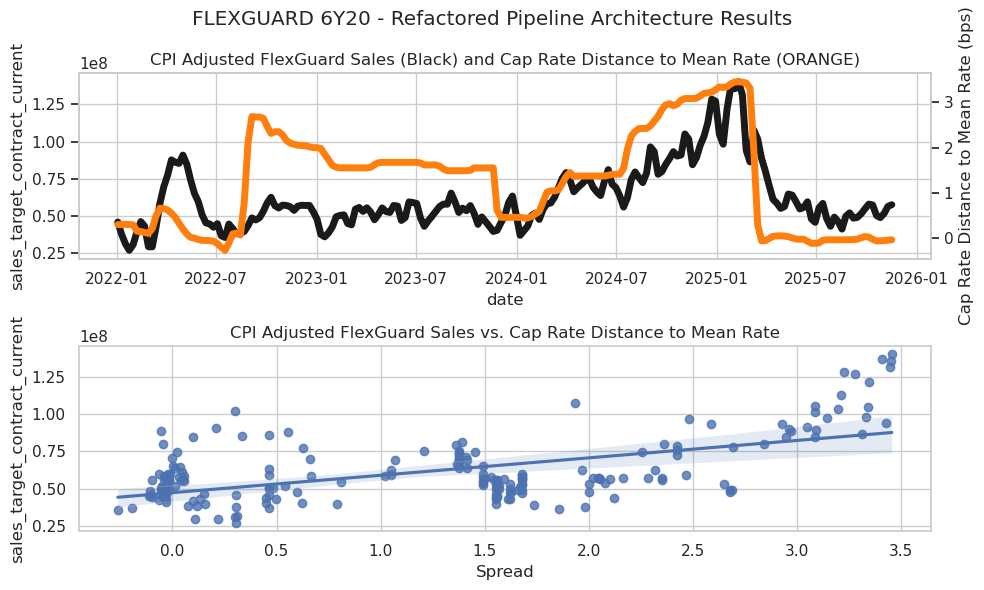


 VISUALIZATION COMPLETE
   Sales range: $27,047,571 to $140,185,577
   Spread range: -0.3 to 3.5 bps
   Correlation (Sales vs Spread): 0.582
time: 618 ms (started: 2026-01-15 23:32:52 +00:00)


In [22]:
# Final visualization
figure, axes = plt.subplots(2, 1, sharex=False, sharey=False, figsize=(fig_width/2, fig_height))
figure.suptitle("FLEXGUARD 6Y20 - Refactored Pipeline Architecture Results")
axes[0].set_title("CPI Adjusted FlexGuard Sales (Black) and Cap Rate Distance to Mean Rate (ORANGE)")

# Key variables for visualization
log_sales_col = "sales_target_contract_current"
spread_col = "Spread"

# Use seaborn directly for dual-axis plotting
sns.lineplot(
    df_weekly_final, x="date", y=log_sales_col,
    ax=axes[0], color="k", linewidth=5
)

ax0 = axes[0].twinx()
ax0.set_ylabel("Cap Rate Distance to Mean Rate (bps)")
ax0.grid(False)
sns.lineplot(
    data=df_weekly_final, x="date", y=spread_col,
    ax=ax0, color="tab:orange", linewidth=5
)

sns.regplot(df_weekly_final, x=spread_col, y=log_sales_col, ax=axes[1], ci=100, order=1)
axes[1].set_title("CPI Adjusted FlexGuard Sales vs. Cap Rate Distance to Mean Rate")

plt.tight_layout()
plt.show()

print(f"\n VISUALIZATION COMPLETE")
print(f"   Sales range: ${df_weekly_final[log_sales_col].min():,.0f} to ${df_weekly_final[log_sales_col].max():,.0f}")
print(f"   Spread range: {df_weekly_final[spread_col].min():.1f} to {df_weekly_final[spread_col].max():.1f} bps")
correlation = df_weekly_final[log_sales_col].corr(df_weekly_final[spread_col])
print(f"   Correlation (Sales vs Spread): {correlation:.3f}")